In [68]:
#Importing all the libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sklearn as sk
import warnings
import re
from getpass import getpass
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
sns.set_palette("husl")


In [69]:
#Creating the connection with the database

password = getpass("Please, insert your password:")
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

In [70]:
#Retrieving the data from the database. I will combine the asked query to get a binary feature in the first one for easier manipulation of the data.
engine = create_engine(connection_string)
query = '''
WITH times_rented AS 
    (SELECT i.film_id, COUNT(*) AS times_rented
    FROM rental AS r
    JOIN inventory AS i USING (inventory_id)
    WHERE r.rental_date BETWEEN '2005-07-01' AND '2005-07-31'
    GROUP BY i.film_id)
SELECT f.film_id, f.length, f.rating, c.name as category, f.rental_rate, f.rental_duration, rc.times_rented,
    CASE 
        WHEN rc.times_rented > AVG(rc.times_rented) OVER () THEN 'High'
        WHEN rc.times_rented <= AVG(rc.times_rented) OVER () THEN 'Low'
        ELSE 'Unknown'
    END AS renting_probability
FROM film AS f
    JOIN film_category AS fc USING (film_id)
    JOIN category AS c USING (category_id)
    JOIN times_rented AS rc USING (film_id)
ORDER BY f.film_id ASC;
'''
rentals = pd.read_sql_query(query, engine)

In [71]:
#Getting the data shape
rentals.shape

(958, 8)

In [72]:
#Getting the data types
rentals.dtypes

film_id                  int64
length                   int64
rating                  object
category                object
rental_rate            float64
rental_duration          int64
times_rented             int64
renting_probability     object
dtype: object

In [73]:
rentals.describe()

,film_id,length,rental_rate,rental_duration,times_rented
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,115.490605,2.977474,4.969729,6.294363
std,287.541738,40.471844,1.643152,1.407593,2.786553
min,1.000000,46.000000,0.990000,3.000000,1.000000
25%,256.250000,80.250000,0.990000,4.000000,4.000000
50%,504.500000,114.000000,2.990000,5.000000,6.000000
75%,751.750000,150.000000,4.990000,6.000000,8.000000
max,1000.000000,185.000000,4.990000,7.000000,16.000000


In [74]:
#Showing the head of the data
rentals.head()

,film_id,length,rating,category,rental_rate,rental_duration,times_rented,renting_probability
0,1,86,PG,Documentary,0.99,6,7,High
1,2,48,G,Horror,4.99,3,2,Low
2,3,50,NC-17,Documentary,2.99,7,4,Low
3,4,117,G,Horror,2.99,5,11,High
4,5,130,G,Family,2.99,6,4,Low


In [75]:
#Checking if there are any NaN values
rentals.isna().sum()

film_id                0
length                 0
rating                 0
category               0
rental_rate            0
rental_duration        0
times_rented           0
renting_probability    0
dtype: int64

In [76]:
#Checking if there are any duplicate rows
rentals.duplicated().sum()

0

In [77]:
#Creating a copy of the data, just in case something goes wrong
rentals_copy = rentals.copy()

In [78]:
#Getting rid of the film_id by converting it to the index, so it also gives us the opportunity to analize the data by film
rentals_copy.set_index('film_id', inplace=True)
rentals_copy.head()

,length,rating,category,rental_rate,rental_duration,times_rented,renting_probability
film_id,,,,,,,
1,86,PG,Documentary,0.99,6,7,High
2,48,G,Horror,4.99,3,2,Low
3,50,NC-17,Documentary,2.99,7,4,Low
4,117,G,Horror,2.99,5,11,High
5,130,G,Family,2.99,6,4,Low


In [79]:
#Checking for balance on the target variable
rentals_copy['renting_probability'].value_counts()

renting_probability
Low     539
High    419
Name: count, dtype: int64

In [80]:
#Preparing the categorical values for the model but keeping the target varieble out of it
categorical = rentals_copy[['rating', 'category']]
target = rentals_copy['renting_probability']

In [81]:
#Checking the unique values of the categorical variables
for col in categorical:
    print(f'{col}: {categorical[col].unique()}')


rating: ['PG' 'G' 'NC-17' 'PG-13' 'R']
category: ['Documentary' 'Horror' 'Family' 'Foreign' 'Comedy' 'Sports' 'Music'
 'Animation' 'Action' 'New' 'Sci-Fi' 'Classics' 'Games' 'Children'
 'Travel' 'Drama']


In [82]:
#Applying the get_dummies function to the categorical variables
categorical = pd.get_dummies(categorical, drop_first = True)
categorical.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
film_id,,,,,,,,,,,,,,,,,,,
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [83]:
#Preparing the numerical values for the model
numerical = rentals_copy.select_dtypes(include = ['int64', 'float64'])
numerical.head()

,length,rental_rate,rental_duration,times_rented
film_id,,,,
1,86,0.99,6,7
2,48,4.99,3,2
3,50,2.99,7,4
4,117,2.99,5,11
5,130,2.99,6,4


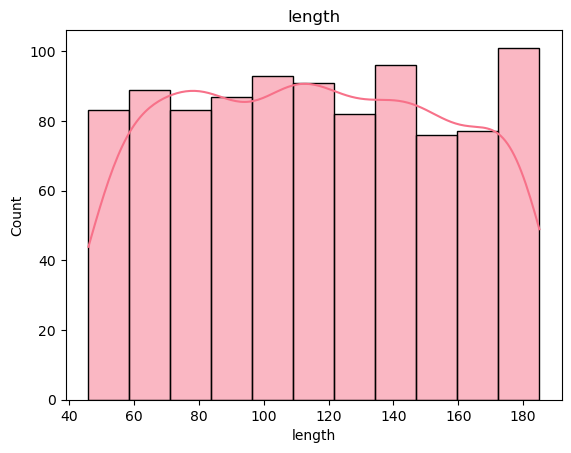

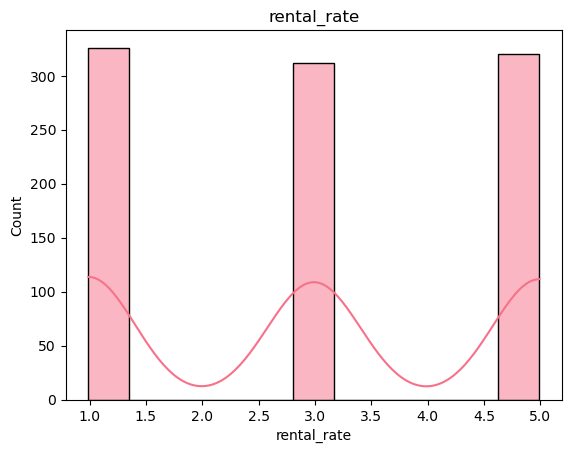

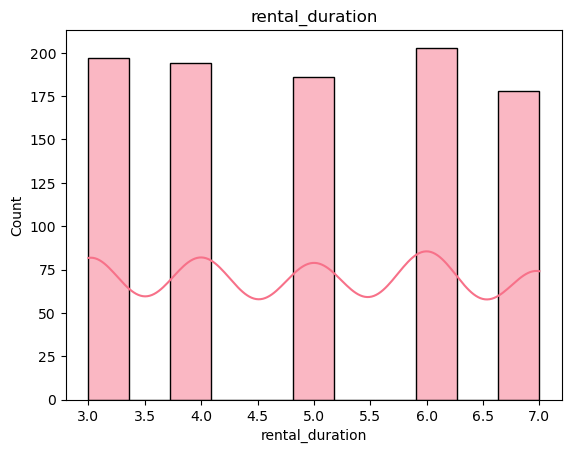

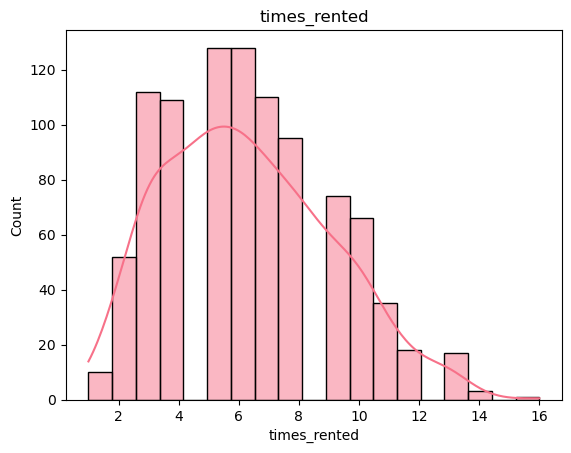

In [84]:
#Plotting the distribution of the numerical variables
for i in numerical.columns:
    sns.histplot(numerical[i], kde = True)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title(i)
    plt.show()

From the plotting we can see that:

-Length is normally distributed

-rental_rate and rental_duration are evenly distributed due to the limited values they have

-times_rented is normally distributed, but a liitle bit skewed to the right.

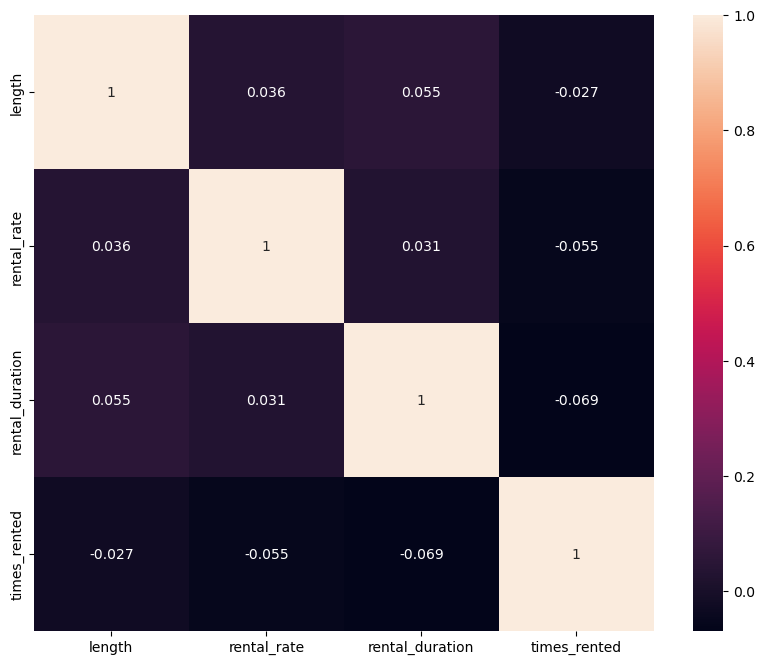

In [85]:
#Checking for multicollinearity
corr_matrix=numerical.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [86]:
#Preparing the data for the model
X = pd.concat([numerical, categorical], axis = 1)
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [87]:
#Training the model:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [88]:
#Getting the results of the model
predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        84
         Low       1.00      1.00      1.00       108

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



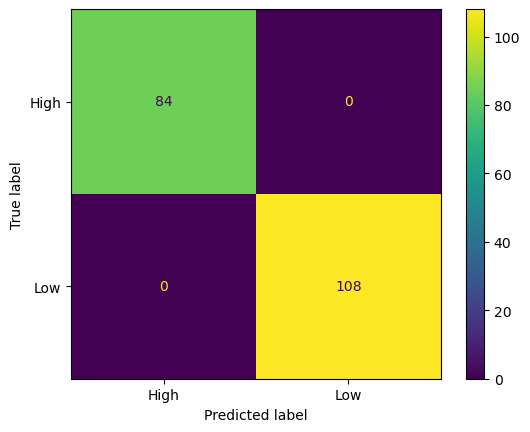

In [89]:
#Plotting the confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification.classes_)
disp.plot()

<Axes: >

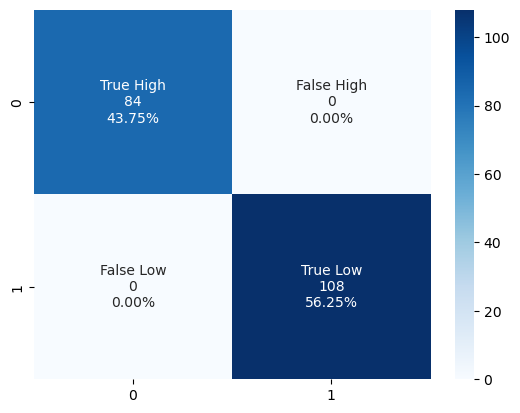

In [90]:
#Showing the results with another plot.
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True High', 'False High', 'False Low', 'True Low']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')